In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/My Drive/Colab Notebooks/deepfake-hunters')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# !pwd

In [2]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib.pyplot import imread

In [8]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# img_height = 224
# img_width = 224
# batch_size = 2

# model = Sequential()
# model.add(layers.Conv2D(16, 3, input_shape=(img_height,img_width,3), padding='same'))
# model.add(layers.Conv2D(32, 3, padding='same'))
# model.add(layers.MaxPool2D(3))
# model.add(layers.Flatten())
# model.add(layers.Dense(10))

In [10]:
# X_train = tf.keras.utils.image_dataset_from_directory(
#     ''
# )

In [3]:
def load_data_train():  
    X_train, y_train = [], []
    
    path = 'raw_data/train/fake'
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for image in images:
        c_path = os.path.join(path, image)
        X_train.append(imread(c_path)[:, :, :3])
        y_train.append(1)
        
    path = 'raw_data/train/real' 
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for image in images:
        c_path = os.path.join(path, image)
        X_train.append(imread(c_path)[:, :, :3])
        y_train.append(0)
        
    c = list(zip(X_train, y_train))
    np.random.shuffle(c)
    X_train, y_train = zip(*c)

        
    return np.array(X_train), np.array(y_train)

In [4]:
X_train, y_train = load_data_train()

In [5]:
def load_data_test():  
    X_test, y_test= [], []
    
    path = 'raw_data/test/fake'
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for image in images:
        c_path = os.path.join(path, image)
        X_test.append(imread(c_path)[:, :, :3])
        y_test.append(1)
        
    path = 'raw_data/test/real' 
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for image in images:
        c_path = os.path.join(path, image)
        X_test.append(imread(c_path)[:, :, :3])
        y_test.append(0)
        
    c = list(zip(X_test, y_test))
    np.random.shuffle(c)
    X_test, y_test = zip(*c)
        
    return np.array(X_test), np.array(y_test)

In [6]:
%%time
X_test, y_test = load_data_test()

CPU times: user 6.28 s, sys: 1.26 s, total: 7.54 s
Wall time: 1min 47s


In [7]:
def load_data_val():  
    X_val, y_val = [], []
    
    path = 'raw_data/val/fake'
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for image in images:
        c_path = os.path.join(path, image)
        X_val.append(imread(c_path)[:, :, :3])
        y_val.append(1)
        
    path = 'raw_data/val/real' 
    images = [f for f in listdir(path) if isfile(join(path, f))]
    for image in images:
        c_path = os.path.join(path, image)
        X_val.append(imread(c_path)[:, :, :3])
        y_val.append(0)
        
    c = list(zip(X_val, y_val))
    np.random.shuffle(c)
    X_val, y_val = zip(*c)
        
    return np.array(X_val), np.array(y_val)

In [8]:
%%time
X_val, y_val = load_data_val()

CPU times: user 6.44 s, sys: 1.27 s, total: 7.7 s
Wall time: 1min 47s


In [9]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def initialize_model():
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(224,224,3)))
    model.add(layers.Conv2D(8, (3,3), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(8, (5,5), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(16, (5,5), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(4,4)))
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, (2,2), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    ### Model compilation
    model.compile(optimizer = "adam",
                  loss = "binary_crossentropy",
                  metrics="accuracy")
    return model

In [10]:
model_homemade = initialize_model()
model_homemade.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 8)       1608      
                                                                 
 batch_normalization_1 (Batc  (None, 107, 107, 8)      3

In [11]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 15, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model_homemade.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             batch_size = 16, 
                             epochs = 100, 
                             callbacks=[es])

Epoch 1/100
1230/1230 [==============================] - 27s 16ms/step - loss: 0.6887 - accuracy: 0.5550 - val_loss: 0.6504 - val_accuracy: 0.5948
Epoch 2/100
1230/1230 [==============================] - 18s 15ms/step - loss: 0.6591 - accuracy: 0.5793 - val_loss: 0.6756 - val_accuracy: 0.5861
Epoch 3/100
1230/1230 [==============================] - 18s 14ms/step - loss: 0.6552 - accuracy: 0.5911 - val_loss: 0.6496 - val_accuracy: 0.5938
Epoch 4/100
1230/1230 [==============================] - 18s 14ms/step - loss: 0.6481 - accuracy: 0.5917 - val_loss: 0.6480 - val_accuracy: 0.6079
Epoch 5/100
1230/1230 [==============================] - 18s 15ms/step - loss: 0.6434 - accuracy: 0.6028 - val_loss: 0.6458 - val_accuracy: 0.6037
Epoch 6/100
1230/1230 [==============================] - 18s 15ms/step - loss: 0.6414 - accuracy: 0.6027 - val_loss: 0.6193 - val_accuracy: 0.6342
Epoch 7/100
1230/1230 [==============================] - 18s 15ms/step - loss: 0.6352 - accuracy: 0.6055 - val_loss: 0

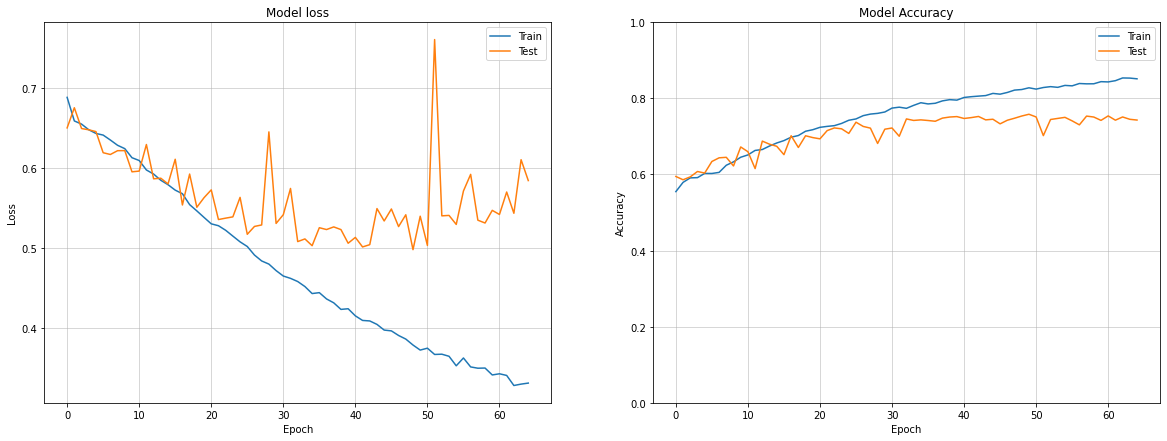

In [12]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    #ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    # --- ACCURACY
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    if title:
        fig.suptitle(title)
plot_loss_accuracy(history)

In [23]:
model_homemade.save('./raw_data/saved_model/model')

In [24]:
res = model_homemade.evaluate(X_test, y_test)
res

188/188 [==============================] - 2s 9ms/step - loss: 0.5384 - accuracy: 0.7502


[0.5384383201599121, 0.7502495646476746]

In [28]:
from tensorflow import expand_dims
from tensorflow.image import resize 
test_img = imread('raw_data/test_all/ff2.jpg')
test_img = resize(test_img, [224,224])

image_full = expand_dims(test_img, 0)
model_homemade.predict(image_full)

1/1 [==============================] - 0s 17ms/step


array([[0.7169193]], dtype=float32)

In [ ]:
# !cat /proc/meminfo

In [ ]:
# images_pd = pd.read_csv('raw_data/metadata.csv') 
# images_pd  = images_pd.drop(columns= ['original_width', 'original_height', 'original'])
# images_data = [[i[0].replace('.mp4', '.jpg'), i[1]] for i in images_pd.values.tolist()]

In [ ]:
# import shutil
# shutil.rmtree('raw_data/fake_224/')
# shutil.rmtree('raw_data/real_224/')
# !mkdir raw_data/fake_224
# !mkdir raw_data/real_224

In [ ]:
# import shutil

# cptfake = 0
# cptreal = 0
# for a in images_data:
#     if a[1] == 'FAKE' and cptfake < 15000:
#         shutil.copy(f'raw_data/faces_224/{a[0]}', 'raw_data/fake_224/')
#         cptfake += 1
#     elif cptreal < 15000:
#         shutil.copy(f'raw_data/faces_224/{a[0]}', 'raw_data/real_224/')
#         cptreal += 1
#     if cptfake == 15000 and cptreal == 15000:
#         break

In [ ]:
# shutil.make_archive('fake_224', 'zip', 'raw_data/', 'fake_224')
# shutil.make_archive('real_224', 'zip', 'raw_data/', 'real_224')

In [ ]:
# !git add Abou_preprocess.ipynb Dataset_split.ipynb
# !git commit -m "ajout fichiers notebook de traitement"
# !git status